# KarłoszPol

### Wgranie potrzebnych pakietów

In [3]:
import numpy as np
import random
import simpy
import matplotlib.pyplot as plt

### Ustalenie zmiennych wejściowych do modelu

In [4]:
# =========== ZMIENNE =============

# liczba stanowisk

machines = 5

# typ myjni

typ_myjni = 'R'

# horyzont analizy - ilość minut działania myjni w ciągu dnia
horyzont = 720

# liczba uruchomień symulacji
iterations = 20

# średnia i odchylenie ilości klientów
clients = 150
clients_std = 10

# pierwszy gorący okres w ciągu dnia - po jakim czasie od otwarcia stacji jest najwięcej klientów ( i z jakim odchyleniem)
happy_hour = 120
happy_hour_std = 30

# drugi gorący okres
happy_hour_2 = 500
happy_hour_2_std = 60

# seed
ziarno = 2137


### Tworzenie składowych modelu

In [5]:
# ====== funkcje oraz klasy pomocnicze ======

# stworzenie rozkładu bimodalnego
def rozklad_binominal(N,mu,sigma,mu2,sigma2):
    
    N=int(N/2)
    X1 = np.random.normal(mu, sigma, N)
    X2 = np.random.normal(mu2, sigma2, N)
    X = np.concatenate([X1, X2])

    return(X)

# klasa definiująca status mycia samochodu -> przypisuje konkretnemu samochodowi pewien czas mycia

class Carwash(object):
    """Myjnia ma ograniczoną liczbę maszyn, z których korzysta równolegle do mycia samochodów.
        Kolejne auta wysyłają prośbę o skorzystanie z jednej z maszyn. Jeżeli otrzymają prośbę to zaczyna się proces mycia.
        W przeciwnym przypadku oczekują w kolejce do momentu otrzymania zgody na mycie.
    """
    def __init__(self, env, num_machines, washtime):
        self.env = env
        self.machine = simpy.Resource(env, num_machines)
        self.washtime = washtime
    def wash(self, car):
        """ Proces mycia. Funkcja bierze konkretny samochód i przypisuje mu czas mycia"""
        yield self.env.timeout(np.random.randint(self.washtime - 2, self.washtime + 2))

# funkcja tworząca obiekt - samochód
        
def car(env, name, cw, stats):
    """Funkcja definiuje kolejne statusy samochodu. Na początku tworzy auto(razem z nazwą) i zapisuje moment,
    w którym przyjechał. Następnie zapisuje kolejne stany samochodu, łącznie z momentem, w którym
    wyjeżdża z myjni
    """
    stats['cars'].append(name)
    arrival_time = env.now
    stats['arrival'].append(arrival_time)
 

    with cw.machine.request() as request:

        yield request
        enter_time = env.now
        stats['enter'].append(enter_time)
        yield env.process(cw.wash(name))
        leave_time = env.now
        stats['leave'].append(leave_time)
    stats['waittimes'].append(enter_time - arrival_time)
    stats['totaltimes'].append(leave_time - arrival_time)
       
def setup(env, num_machines, washtime, events, stats):
    """Funkcja uruchamiająca, która tworzy myjnię, ustala pierwszych czterech klientów
    i tworzy kolejnych, na podstawie czasów przyjazdu z rozkładu bimodalnego"""
    # Stworzenie myjni
    carwash = Carwash(env, num_machines, washtime)
    # Stworzenie 4 początkowych samochodow
    for i in range(4):
        env.process(car(env, f'Car {i}', carwash, stats))
        3
        # Tworzenie kolejnych samochodów
    while True:
        for j in events:
            yield env.timeout(j)
            i += 1
            env.process(car(env, f'Car {i}', carwash, stats))


### Model

In [6]:
def model(N,N_sigma,mu, sigma,mu2,sigma2, n_machines, rodzaj, horizont,r_seed = ziarno):
    
    np.random.seed(r_seed)
    # losowa liczba populacji z rozkładu normalnego
    pop_size=int(np.random.normal(N, N_sigma))
    
    # zapewnienie zdarzeń z rozkładu dwumodalnego
    events=rozklad_binominal(pop_size,mu,sigma,mu2,sigma2)
    events = np.sort(events)
    for i,j in enumerate(events):
   
        if j < 0:
            events[i] = 0
        elif j>horizont:
            events[i] = horizont
    events = np.diff(events)
    events = np.round(events,2)
    events = np.delete(events,np.where(events == 0))
    
    if rodzaj == 'R':
        wash_t = 12 # minut
    elif rodzaj =='M':
        wash_t = 7 # minut
    
    # lista na zapisywanie wyników, w jakim czasie samochody odbywały kolejne czynności
    stats = {}
    stats['cars'] = []
    stats['arrival'] = []
    stats['enter'] =[]
    stats['leave'] =[]
    stats['waittimes'] = []
    stats['totaltimes'] = []
    
    #uruchomienie symulacji
    env = simpy.Environment()
    env.process(setup(env, n_machines, wash_t,events, stats))
    env.run(until=horizont)

    #zapewnienie, że samochody, które wjechały ale nie zdążyły się umyć wyjadą (dodanie czasu opuszczenia)
    stats['leave'].extend([horizont]* (len(stats['arrival'])-len(stats['leave'])))
    stats['enter'].extend([horizont]* (len(stats['arrival'])-len(stats['enter'])))

    # policzenie czasów oczekiwania i czasu całkowitego
    for k in range(len(stats['waittimes']),len(stats['arrival'])):
        stats['waittimes'].append(stats['enter'][k]-stats['arrival'][k])

    for k in range(len(stats['totaltimes']),len(stats['arrival'])):
        stats['totaltimes'].append(stats['leave'][k]-stats['arrival'][k])
    
    
    
    
    # wynik to całkowity czas spedzony na myjni
    return(sum(stats['totaltimes'])-sum(stats['waittimes']))

### Funkcja definiująca iteracje wyników modelu

In [7]:
def run_model (iterations,N,N_sigma,mu, sigma,mu2,sigma2, n_machines, rodzaj, horizont,r_seed):
    avg_t_cum = []
    for i in range (iterations):
        avg_t_cum.append(model(N,N_sigma,mu, sigma,mu2,sigma2, n_machines, rodzaj, horizont,r_seed))
        r_seed += i
    return (avg_t_cum)

### Zapewnienie horyzontu 365 dni

In [8]:
def w_czasie(dni, typ_myjni,machines):
    avg_time=[]
    for i in range(dni):
        avg_time.append(np.average(run_model(iterations,clients,clients_std,happy_hour,happy_hour_std,happy_hour_2,happy_hour_2_std,machines,typ_myjni,horyzont,ziarno)))
    return(np.sum(avg_time))
    

### Funkcja uzupełniająca wynik modelu o koszty - otrzymanie zysku rocznego

In [9]:
def zysk_roczny(machines,typ_myjni):
    
    if typ_myjni =='M':
        cena=2
        budowa = 20000
        koszt_jednostkowy = 1.2
    elif typ_myjni =="R":
        cena=1
        budowa=15000
        koszt_jednostkowy=0.5

    suma_minut=w_czasie(365,typ_myjni,machines)
    przychod=suma_minut*cena
    koszt=budowa*machines+koszt_jednostkowy*suma_minut
    zysk=przychod-koszt
    
    return[przychod,koszt,zysk]

### Wynik dla myjni typu ręcznego (5 stanowisk)

In [10]:
zysk_roczny(machines,'R')[2]

337929.9750000002

### Wynik dla myjni typu mechanicznego (5 stanowisk)

In [11]:
zysk_roczny(machines,'M')[2]

307267.87600000005

# Analiza wrażliwości

### Wpływ zmiany liczby maszyn oraz kosztu budowy na zysk (w podziale na typ myjni)

In [13]:
results2 ={}

for machines in range(1,6):
    for i in range(0,2):
        if i==0:
            typ_myjni="R"
            cena=1
            koszt_jednostkowy=0.5
        else:
            typ_myjni="M"
            cena=2
            koszt_jednostkowy=1.2
            
        suma_minut=w_czasie(365,typ_myjni,machines)

        for budowa in range(5000, 20000, 2000):
            przychod=suma_minut*cena
            koszt=budowa*machines+koszt_jednostkowy*suma_minut
            zysk=przychod-koszt
            #print(f"cena - {cena}, koszt jednostkowy - {koszt_jednostkowy},budowa - {budowa}, zysk - {zysk})
            results2.setdefault((machines,typ_myjni,cena,koszt_jednostkowy,budowa),[]).append([zysk])


In [14]:

vals = [r for r in results2.keys()]
zyski=[r for r in results2.values()]

profit = [v[0][0] for v in zyski]
typ=[v[1] for v in vals]
stanowiska=[v[0] for v in vals]
budowa=[v[4] for v in vals]


data2 = pd.DataFrame({'stanowiska':stanowiska,'typ': typ,'budowa':budowa,'zysk' : profit })



AttributeError: Use the `.axes` attribute when facet variables are assigned.

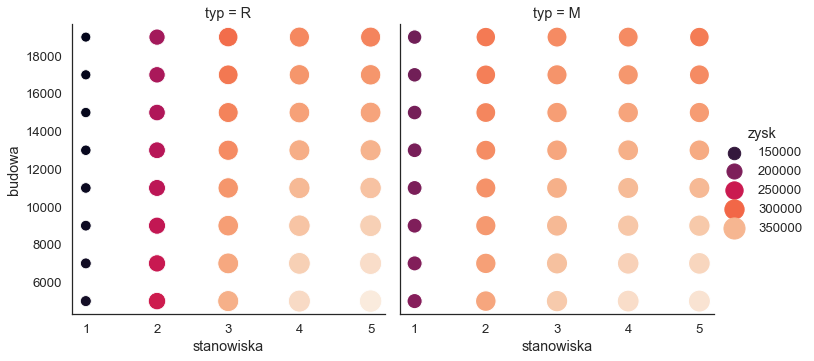

In [46]:
sns.set_style("white")

cmap = sns.color_palette("rocket", as_cmap=True)
g = sns.relplot(
    data=data2,
    x="stanowiska", y="budowa",
    hue="zysk",
    size="zysk",
    col="typ",
    palette=cmap,
    sizes=(100, 500)
)


g.ax.xaxis.grid(True)
g.despine(left=True, bottom=True)



### Wpływ zmiany liczby maszyn na zysk (w podziale na typ myjni)

In [16]:
results3 ={}


for machines in range(1,6):
    for i in range(0,2):
        if i==0:
            typ_myjni="R"
            cena=1
            koszt_jednostkowy=0.5
            budowa=15000
        else:
            typ_myjni="M"
            cena=2
            koszt_jednostkowy=1.2
            budowa=20000
            
        suma_minut=w_czasie(365,typ_myjni,machines)
        
        przychod=suma_minut*cena
        koszt=budowa*machines+koszt_jednostkowy*suma_minut
        zysk=przychod-koszt
        #print(f"cena - {cena}, koszt jednostkowy - {koszt_jednostkowy},budowa - {budowa}, zysk - {zysk})
        results3.setdefault((machines,typ_myjni,cena,koszt_jednostkowy,budowa),[]).append([zysk])

In [17]:

vals = [r for r in results3.keys()]
zyski=[r for r in results3.values()]

profit = [v[0][0] for v in zyski]
typ=[v[1] for v in vals]
stanowiska=[v[0] for v in vals]



data3 = pd.DataFrame({'stanowiska':stanowiska,'typ': typ,'zysk' : profit })

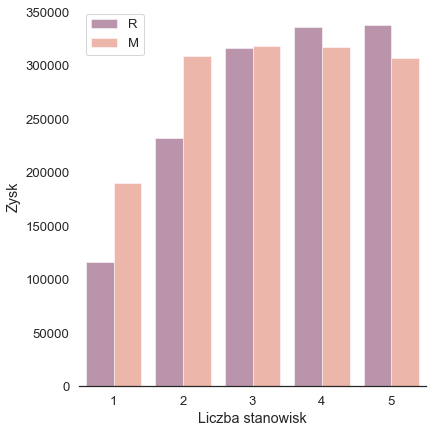

In [43]:
#sns.set_style("white")
sns.set(font_scale=1.2,style="white")


g = sns.catplot(
    data=data3, kind="bar",
    x="stanowiska", y="zysk", hue="typ",
    ci="sd", palette="rocket", alpha=.5, height=6, legend=False
)
g.despine(left=True)
g.set_axis_labels("Liczba stanowisk", "Zysk")
#g.legend.set_title("Typ myjni")
g.ax.legend(loc=2)

### Wynik finansowy oddziału myjni w czasie

In [80]:

dni=365
avg_time_daily=[]
for i in range(dni):
    ziarno=random.randint(1,1000)
    #r_seed=random.random()
    czas=np.average(run_model(iterations,clients,clients_std,happy_hour,happy_hour_std,happy_hour_2,happy_hour_2_std,machines,typ_myjni,horyzont,ziarno))
    avg_time_daily.append([czas])


In [179]:
machines=5
cena=1
koszt_jednostkowy=0.5
budowa=15000

def wyliczenie_zysku(suma_minut):
    przychod=suma_minut*cena
    koszt=koszt_jednostkowy*suma_minut
    zysk=przychod-koszt
    return zysk

        
avg_min = [i[0] for i in avg_time_daily]

lista_zyskow = []
for suma_minut in avg_min:
    try:
        lista_zyskow.append(wyliczenie_zysku(suma_minut))
    except TypeError:
        lista_zyskow.append(wyliczenie_zysku(suma_minut[0]))


avg_df = pd.DataFrame.from_dict(dict(suma_minut=avg_min, zysk = lista_zyskow))

avg_df.zysk[0]=avg_df.zysk[0]-budowa*machines

<ipython-input-179-f34c84f6b071>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_df.zysk[0]=avg_df.zysk[0]-budowa*machines


In [194]:
dzien=[*range(1,366)]
zysk2_list = []
for ind in avg_df['zysk'].index:
    if ind == 0:
        zysk2 = avg_df['zysk'][ind]
        zysk2_list.append(zysk2)
    else:
        zysk2 = zysk2 + avg_df['zysk'][ind]
        zysk2_list.append(zysk2)
avg_df['zysk2'] = zysk2_list
avg_df['dzien'] = dzien



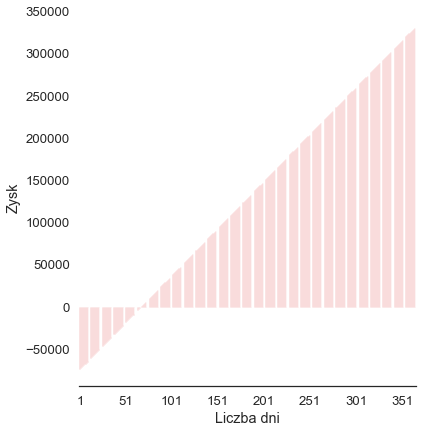

In [200]:
sns.set(font_scale=1.2,style="white")


g = sns.catplot(
    data=avg_df, kind="bar",
    x="dzien", y="zysk2",
    ci="sd", color="red", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Liczba dni", "Zysk")
g.set(xticks=range(0,356,50))